# Stock Prediction - LSTM 

## Import Libraries

In [3]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\wgutierrezp\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Ingest Data 

In [4]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 
#Show the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2003 entries, 2012-01-03 to 2019-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2003 non-null   float64
 1   Low        2003 non-null   float64
 2   Open       2003 non-null   float64
 3   Close      2003 non-null   float64
 4   Volume     2003 non-null   float64
 5   Adj Close  2003 non-null   float64
dtypes: float64(6)
memory usage: 109.5 KB


## Exploratory Data Analysis

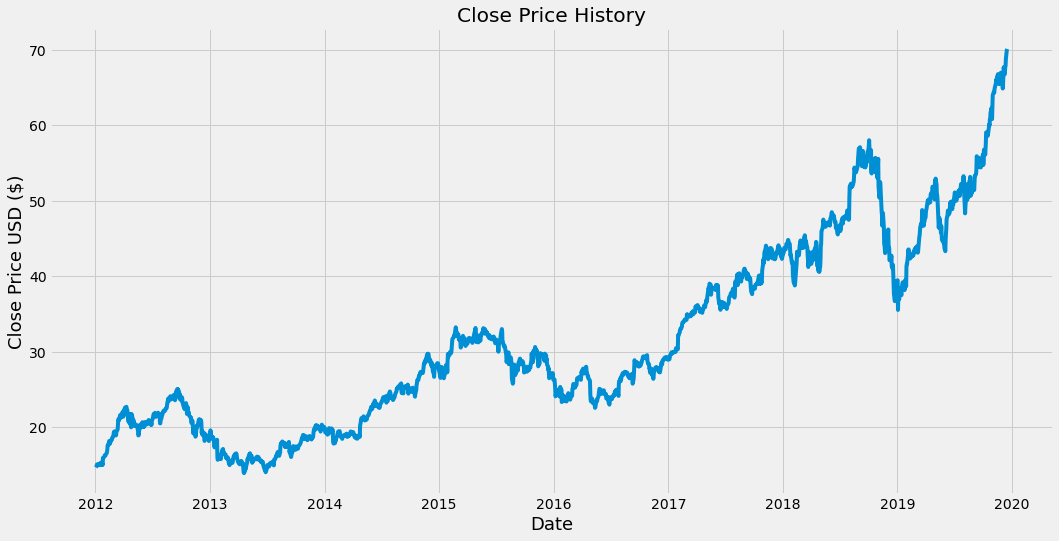

In [5]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [6]:
report = df.profile_report()
report.to_file('eda_stock_report.html')

## Data Preprocessing & Wrangling

In [122]:
#Select closing data
df_close = df[['Close']]

In [12]:
#Scale the data
scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(df_close)
X.shape

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
training_data_len = math.ceil( len(df_close) *.8)
train_data = X[0:training_data_len  , : ]
X_train,X_test = train_test_split(X, test_size=0.2 ,shuffle=False)

x_train=[]
y_train = []
for i in range(60,len(X_train)):
    x_train.append(X_train[i-60:i,0])
    y_train.append(X_train[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

## Model Training

In [15]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(keras.layers.LSTM(units=50, return_sequences=False))
model.add(keras.layers.Dense(units=25))
model.add(keras.layers.Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

In [125]:
model.save('models/LSTM_60D')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/LSTM_60D\assets


## Model Evaluation

In [53]:
#Test data set
test_data = X[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test = scaler.inverse_transform(X[training_data_len:, :]) #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
print(x_test.shape)
print(y_test.shape)

(400, 60)
(400, 1)


In [45]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [46]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [54]:
from sklearn.metrics import accuracy_score, mean_squared_error
rmse = mean_squared_error(predictions, y_test,squared=False)
rmse

<ipython-input-57-d66e7487486a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


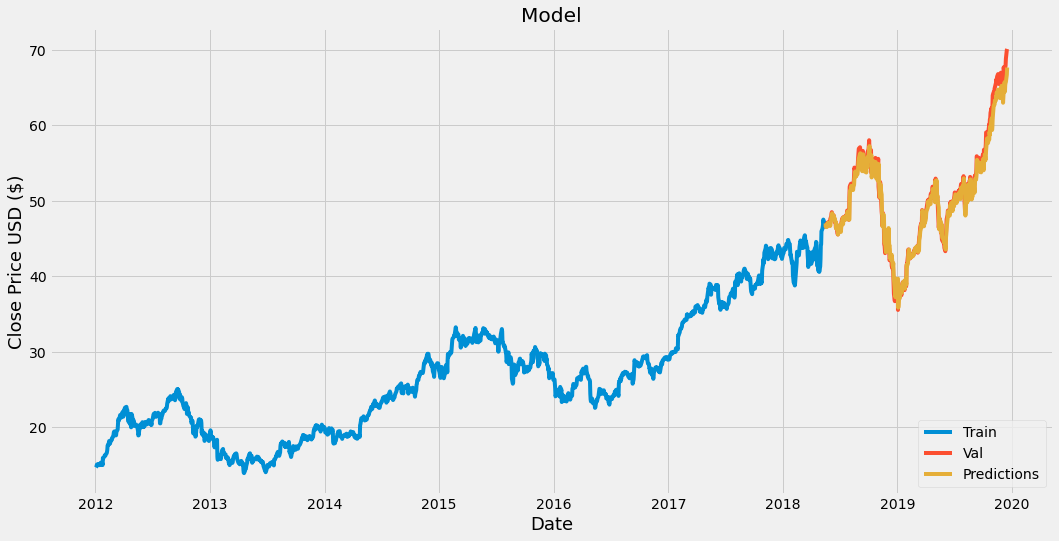

In [57]:
#Plot/Create the data for the graph
train = df_close[:training_data_len]
valid = df_close[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Generate Output Dataframe

In [61]:
X.shape

(2003, 1)

In [82]:
%load_ext autoreload

%autoreload 2
from utils.preprocessing import compute_stock_features

x, y = compute_stock_features(X)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1943, 60)


In [123]:
p_list = [np.zeros(x.shape[1]),model.predict(x)]
df_close['Predictions'] = np.array([i for l in p_list for i in l])

<ipython-input-123-d16129c5e9e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['Predictions'] = np.array([i for l in p_list for i in l])
